# MNIST with sklearn

The goal of this exercise is to 
* explore some of the sklearn functionality for training a MLP classifier (see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)  
* by using cross validation 
* learn how to compute the confusion matrix and its derived quantities and how to interpret them
* explore the test error as a function of the complexity (number of units, number of layers)
* explore the impact of L2 regularisation

__IMPORTANT REMARK__: We here follow the convention of sklearn to enumerate the samples with the first index. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Load and prepare the data 

In [2]:
datadir = 'data/'

In [3]:
def normalize(x_train,x_test):
    """
    Normalizes the pixels values of the images - mean and stdev are computed from the training set.
    
    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train -= mean
    x_test -= mean
    x_train /= std
    x_test /= std
    return x_train, x_test

In [4]:
# in case you have trouble with the fetch_openml, use this code
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
x,y = fetch_openml('mnist_784', data_home=datadir, return_X_y=True)
x_train0, x_test0, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=1)
x_train, x_test = normalize(x_train0, x_test0)

## Specify Model Family and learn how to compute the metrics

#### Model
Use the functionality of scikit learn to configure a MLP and its training procedure with
* hidden layers: 0-2 layers with suitable number of units per layer
* mini-batch gradient descent with given batch_size (no advanced optimisers)
* constant learning rate (no learning rate schedules)
* number of epochs
* no regularisation such as L2 penalty or early stopping

#### Metrics
Compute the train and test error resp. accuracy as well as the class precision, recall, f1-score.

__See__:
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

## First Training Run

Run the training and plot the training loss with a first set of values:
* no hidden layers
* mini-batchsize: 64
* learning rate: 0.1
* 100 epochs

Compute the Metrics.
Which digits are hard to predict?  

#### MODEL

Text(0.5, 1.0, 'Loss curve')

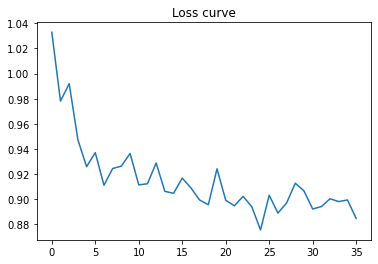

In [6]:
from sklearn.neural_network import MLPClassifier

# Basic Hyperparameters
hidden_layer_sizes = ()
batch_size = 64
learning_rate = 0.1
nepochs = 100

# Regularisation:
alpha = 0.0 # L2 regularisation constant
early_stopping = False
n_iter_no_change = 10

### START YOUR CODE ###
# Model instantiation and training
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    batch_size=batch_size,
                    learning_rate='constant',
                    learning_rate_init=learning_rate,
                    max_iter=nepochs,
                    alpha=alpha,
                    early_stopping=early_stopping,
                    n_iter_no_change=n_iter_no_change,
                    solver='sgd')
mlp.fit(x_train, y_train)

# Plot loss curve
plt.plot(mlp.loss_curve_)
plt.title('Loss curve')
### END YOUR CODE ###

#### METRICS

In [7]:
### START YOUR CODE ###
# train and test error, accuracy
# per class accuracy, precision, f1 score
from sklearn.metrics import accuracy_score, classification_report

y_pred_train = mlp.predict(x_train)
y_pred_test = mlp.predict(x_test)

print('Train Set:')
print('Accuracy Score: %.2f' % accuracy_score(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

print('\n')
print('Test Set:')
print('Accuracy Score: %.2f' % accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
### END YOUR CODE ###

Train Set:
Accuracy Score: 0.90
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       959
           1       0.98      0.91      0.95      1186
           2       0.81      0.92      0.86      1035
           3       0.93      0.72      0.81      1031
           4       0.87      0.89      0.88       941
           5       0.76      0.90      0.82       930
           6       0.92      0.93      0.92       942
           7       0.87      0.94      0.90      1050
           8       0.78      0.82      0.80       936
           9       0.91      0.82      0.86       990

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.88     10000



Test Set:
Accuracy Score: 0.88
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       959
           1       0.98      0.91      0.95      1186
           2 

## Best Model without Hidden Layer

By first varying just the parameters 
* mini-batchsize
* learning rate
* epochs

with adding any hidden layer.

Summarize what the best combination of the abover hyper-parameters is.

In [8]:
### START YOUR CODE ###
from sklearn.model_selection import GridSearchCV

# Keep hidden_layer_sizes = () 
# Vary the following

batch_size = 64
learning_rate = 0.1
nepochs = 100

mlp = MLPClassifier(hidden_layer_sizes=(),
                    learning_rate='constant')

parameters = {
    'batch_size': [32, 64, 128, 256, 512],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1,],
    'max_iter': [25, 50, 100],
}

grid_clf = GridSearchCV(mlp, parameters, 
                        n_jobs=-1, cv=5, 
                        verbose=2, return_train_score=True)
grid_clf.fit(x_train, y_train)
### END YOUR CODE ###

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.9min finished
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(hidden_layer_sizes=()), n_jobs=-1,
             param_grid={'batch_size': [32, 64, 128, 256, 512],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
                         'max_iter': [25, 50, 100]},
             return_train_score=True, verbose=2)

In [9]:
print('Best parameters found:\n %s' % grid_clf.best_params_)

print('Scores:')
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
    print("test err: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'batch_size': 128, 'learning_rate_init': 0.0001, 'max_iter': 100}
Scores:
test err: 0.923 (+/-0.001) for {'batch_size': 32, 'learning_rate_init': 0.0001, 'max_iter': 25}
test err: 0.924 (+/-0.003) for {'batch_size': 32, 'learning_rate_init': 0.0001, 'max_iter': 50}
test err: 0.924 (+/-0.002) for {'batch_size': 32, 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.919 (+/-0.003) for {'batch_size': 32, 'learning_rate_init': 0.001, 'max_iter': 25}
test err: 0.915 (+/-0.002) for {'batch_size': 32, 'learning_rate_init': 0.001, 'max_iter': 50}
test err: 0.914 (+/-0.004) for {'batch_size': 32, 'learning_rate_init': 0.001, 'max_iter': 100}
test err: 0.883 (+/-0.021) for {'batch_size': 32, 'learning_rate_init': 0.01, 'max_iter': 25}
test err: 0.893 (+/-0.011) for {'batch_size': 32, 'learning_rate_init': 0.01, 'max_iter': 50}
test err: 0.876 (+/-0.021) for {'batch_size': 32, 'learning_rate_init': 0.01, 'max_iter': 100}
test err: 0.883 (+/-0.033) for {'batch_size

In [10]:
print('Train error: %.3f (+/-%0.03f)' % (grid_clf.cv_results_['mean_train_score'].mean(),
                                        grid_clf.cv_results_['std_train_score'].mean()))
print('Test error: %.3f (+/-%0.03f)' % (grid_clf.cv_results_['mean_test_score'].mean(),
                                        grid_clf.cv_results_['std_test_score'].mean()))

Train error: 0.920 (+/-0.005)
Test error: 0.905 (+/-0.005)


__BEST MODEL__ (no hidden layer)

batch_size = 128

learning_rate = 0.0001

nepochs = 100

train / validation error : 0.920 (+/-0.005) / 0.905 (+/-0.005)

## Adding one Hidden layer

Explore the performance of the model by varying the parameters 
* mini-batchsize
* learning rate
* epochs
* complexity (number of units in the one hidden layer)

For given complexity, summarize what the best combination of other hyper-parameters is - compute this for several complexities.

Compute also the "best" train and validation error (or accuracy) for given complexity - as a function of the complexity and plot the curve (for selected number of units - e.g. 10 different values). 


In [12]:
### START YOUR CODE ###

# Keep hidden_layer_sizes = () 
# Vary the following

hidden_layer_sizes = (100,) # just one layer 
batch_size = 64
learning_rate = 0.1
nepochs = 100

mlp = MLPClassifier(hidden_layer_sizes=(),
                    learning_rate='constant')

parameters = {
    'batch_size': [128],
    'learning_rate_init': [0.0001],
    'max_iter': [100],
    'hidden_layer_sizes': [(int(x),) for x in np.linspace(10, 1000, 10)],
}

grid_clf = GridSearchCV(mlp, parameters, 
                        n_jobs=-1, cv=5, 
                        verbose=2, return_train_score=True)
grid_clf.fit(x_train, y_train)
### END YOUR CODE ###

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed: 151.1min remaining: 109.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 232.5min finished


GridSearchCV(cv=5, estimator=MLPClassifier(hidden_layer_sizes=()), n_jobs=-1,
             param_grid={'batch_size': [128],
                         'hidden_layer_sizes': [(10,), (120,), (230,), (340,),
                                                (450,), (560,), (670,), (780,),
                                                (890,), (1000,)],
                         'learning_rate_init': [0.0001], 'max_iter': [100]},
             return_train_score=True, verbose=2)

In [13]:
print('Best parameters found:\n %s' % grid_clf.best_params_)

print('Scores:')
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
    print("test err: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'batch_size': 128, 'hidden_layer_sizes': (780,), 'learning_rate_init': 0.0001, 'max_iter': 100}
Scores:
test err: 0.932 (+/-0.004) for {'batch_size': 128, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.976 (+/-0.001) for {'batch_size': 128, 'hidden_layer_sizes': (120,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.978 (+/-0.001) for {'batch_size': 128, 'hidden_layer_sizes': (230,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.002) for {'batch_size': 128, 'hidden_layer_sizes': (340,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.001) for {'batch_size': 128, 'hidden_layer_sizes': (450,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.001) for {'batch_size': 128, 'hidden_layer_sizes': (560,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.001) for {'batch_size': 128, 'hidden_layer_sizes': (670,), 'learning_rate_init': 0

In [14]:
print('Train error: %.3f (+/-%0.03f)' % (grid_clf.cv_results_['mean_train_score'].mean(),
                                        grid_clf.cv_results_['std_train_score'].mean()))
print('Test error: %.3f (+/-%0.03f)' % (grid_clf.cv_results_['mean_test_score'].mean(),
                                        grid_clf.cv_results_['std_test_score'].mean()))

Train error: 0.994 (+/-0.000)
Test error: 0.975 (+/-0.001)


__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

In [52]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, big=False):
    # Get Train/Test Scores Mean
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    
    scores_mean_train = cv_results['mean_train_score']
    scores_mean_train = np.array(scores_mean_train).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    if big:
        _, ax = plt.subplots(1,1, figsize=(16,4))
    else:
        _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val) + ' (test)')
        ax.plot(grid_param_1, scores_mean_train[idx,:], '-.o', label= name_param_2 + ': ' + str(val) + ' (train)')

    ax.set_title("Error vs. Complexity")
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('CV Average Score')
    if big:
        ax.tick_params(axis='x', labelsize=6)
    ax.legend(loc="best")
    ax.grid('on')

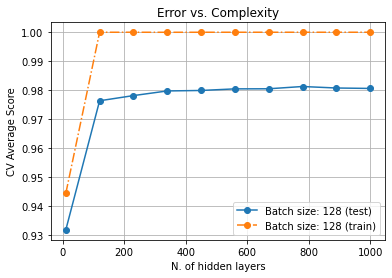

In [20]:
### START YOUR CODE ###

plot_grid_search(grid_clf.cv_results_, [(int(x),) for x in np.linspace(10, 1000, 10)], [128], 'N. of hidden layers', 'Batch size')

### END YOUR CODE ###

__BEST MODEL__ (one hidden layer)

hidden_layer_sizes = (780,)

batch_size = 128

learning_rate = 0.0001

nepochs = 100

train / validation error : 0.994 (+/-0.000) / 0.975 (+/-0.001)

## Impact of Regularisation

Explore the Impact of Using L2 Regularisation (still adding just one hidden layer) again by varying mini-batchsize, learning rate, epochs, complexity.

Can you reach a better best model performance (on validation set)?

In [22]:
### START YOUR CODE ###

# Vary the following

# Basic Hyperparameters
hidden_layer_sizes = (100,)
batch_size = 64
learning_rate = 0.1
nepochs = 100

# Regularisation:
alpha = 0.0 # L2 regularisation constant

mlp = MLPClassifier(hidden_layer_sizes=(),
                    learning_rate='constant')

parameters = {
    'batch_size': [128],
    'learning_rate_init': [0.0001],
    'max_iter': [100],
    'hidden_layer_sizes': [(int(x),) for x in np.linspace(10, 1000, 5)],
    'alpha': [0.0, 0.1],
}

grid_clf = GridSearchCV(mlp, parameters, 
                        n_jobs=-1, cv=5, 
                        verbose=2, return_train_score=True)
grid_clf.fit(x_train, y_train)

### END YOUR CODE ###

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed: 162.6min remaining: 117.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 296.7min finished
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(hidden_layer_sizes=()), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1], 'batch_size': [128],
                         'hidden_layer_sizes': [(10,), (257,), (505,), (752,),
                                                (1000,)],
                         'learning_rate_init': [0.0001], 'max_iter': [100]},
             return_train_score=True, verbose=2)

In [23]:
print('Best parameters found:\n %s' % grid_clf.best_params_)

print('Scores:')
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
    print("test err: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (752,), 'learning_rate_init': 0.0001, 'max_iter': 100}
Scores:
test err: 0.934 (+/-0.004) for {'alpha': 0.0, 'batch_size': 128, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.979 (+/-0.002) for {'alpha': 0.0, 'batch_size': 128, 'hidden_layer_sizes': (257,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.001) for {'alpha': 0.0, 'batch_size': 128, 'hidden_layer_sizes': (505,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.002) for {'alpha': 0.0, 'batch_size': 128, 'hidden_layer_sizes': (752,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.981 (+/-0.001) for {'alpha': 0.0, 'batch_size': 128, 'hidden_layer_sizes': (1000,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.931 (+/-0.004) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test e

__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

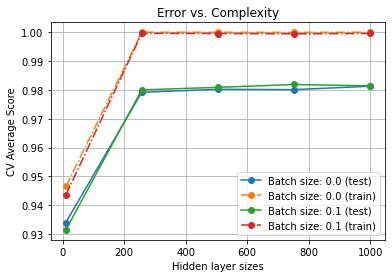

In [26]:
### START YOUR CODE ###

plot_grid_search(grid_clf.cv_results_, [(int(x),) for x in np.linspace(10, 1000, 5)], [0.0, 0.1], 'Hidden layer sizes', 'Batch size')

### END YOUR CODE ###

__BEST MODEL__ (one hidden layer)

hidden_layer_sizes = (752,)

batch_size = 128

learning_rate = 0.0001

nepochs = 100

alpha =  0.1 # L2 regularisation constant

train / validation error : 0.982 (+/-0.002)

## Adding up to 3 Hidden Layers

Now consider using a model with more than one hidden layer (at max 3).


In [29]:
### START YOUR CODE ###

# Vary the following

# Basic Hyperparameters
hidden_layer_sizes = (100,0,0)
batch_size = 64
learning_rate = 0.1
nepochs = 100

# Regularisation:
alpha = 0.0 # L2 regularisation constant

mlp = MLPClassifier(hidden_layer_sizes=(),
                    learning_rate='constant')

hidden_layer_sizes =  [(int(x),) for x in np.linspace(10, 500, 5)] # single
hidden_layer_sizes += [(int(x),int(x)) for x in np.linspace(10, 500, 5)] # double
hidden_layer_sizes += [(int(x),int(x), int(x)) for x in np.linspace(10, 500, 5)] # trible

parameters = {
    'batch_size': [128],
    'learning_rate_init': [0.0001],
    'max_iter': [100],
    'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': [0.1],
}

grid_clf = GridSearchCV(mlp, parameters, 
                        n_jobs=-1, cv=5, 
                        verbose=2, return_train_score=True)
grid_clf.fit(x_train, y_train)

### END YOUR CODE ###

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed: 342.2min remaining: 46.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 361.5min finished
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(hidden_layer_sizes=()), n_jobs=-1,
             param_grid={'alpha': [0.1], 'batch_size': [128],
                         'hidden_layer_sizes': [(10,), (132,), (255,), (377,),
                                                (500,), (10, 10), (132, 132),
                                                (255, 255), (377, 377),
                                                (500, 500), (10, 10, 10),
                                                (132, 132, 132),
                                                (255, 255, 255),
                                                (377, 377, 377),
                                                (500, 500, 500)],
                         'learning_rate_init': [0.0001], 'max_iter': [100]},
             return_train_score=True, verbose=2)

In [30]:
print('Best parameters found:\n %s' % grid_clf.best_params_)

print('Scores:')
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
    print("test err: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (500, 500), 'learning_rate_init': 0.0001, 'max_iter': 100}
Scores:
test err: 0.932 (+/-0.005) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.979 (+/-0.002) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (132,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.980 (+/-0.002) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (255,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.981 (+/-0.001) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (377,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.981 (+/-0.002) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (500,), 'learning_rate_init': 0.0001, 'max_iter': 100}
test err: 0.934 (+/-0.003) for {'alpha': 0.1, 'batch_size': 128, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.0001, 'max_iter': 100}


__Error vs Complexity__:

Plot with the train and test error vs complexity (number of units in the hidden layer)

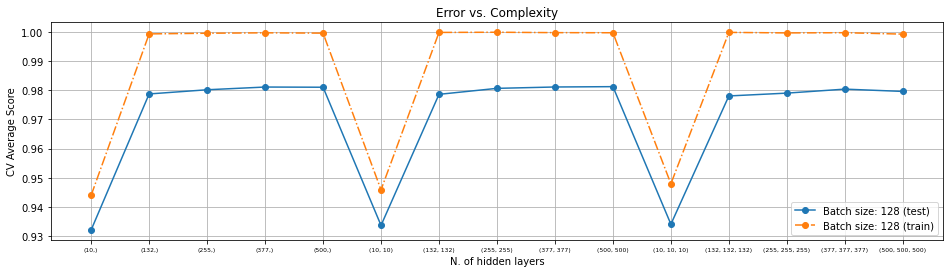

In [51]:
### START YOUR CODE ###

plot_grid_search(grid_clf.cv_results_, [str(x) for x in hidden_layer_sizes], 
                 [128], 'N. of hidden layers', 'Batch size', big=True)

### END YOUR CODE ###

__BEST MODEL__ (1-3 hidden layers)

hidden_layer_sizes = (500, 500)

batch_size = 128

learning_rate = 0.0001

nepochs = 100

alpha =  0.1 # L2 regularisation constant

train / validation error : 0.981 (+/-0.001)

## Test Performance of Best Model

Test Error: 0.984

In [53]:
y_pred_train = grid_clf.best_estimator_.predict(x_train)
y_pred_test = grid_clf.best_estimator_.predict(x_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print('Train acc: %.3f' % acc_train)
print('Test acc: %.3f' % acc_test)

Train acc: 1.000
Test acc: 0.984
